In [1]:
# Fill in your name using the format below and student ID number
your_name = "Zhou, Fangqin"
student_id = "1423126"

In [2]:
# Before submission, set this to True so that you can render and verify this notebook without training deep learning models.
# Any deep learning models will be trained from file instead.
stop_training = True

In [3]:
# Uncomment the following line to run in Google Colab
# !pip install --quiet openml 

In [4]:
# # Uncomment the following line to run in Google Colab
# %tensorflow_version 2.x
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [6]:
from packaging import version
import sklearn
import tensorflow
sklearn_version = sklearn.__version__
tensorflow_version = tensorflow.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(tensorflow_version) < version.parse("2.1.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.1.".format(tensorflow_version))
else:
    print("Hi{}, Looks good. You may continue :)".format(your_name.split(",")[1]))

Tensorflow is outdated. This is version 2.0.0. Please update to 2.1.


# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-yourname'

In [7]:
# base_dir = '/content/drive/My Drive/assignment-3-zhoufangqin' # For Google Colab
base_dir = './'

In [8]:
#Uncomment to link Colab notebook to Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are.
* When questions ask you to provide an explanation, it should be less than 500
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* Be original. We will check for plagiarism between student submissions.

### Data
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build models that recognize the correct digit.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [9]:
# Use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
import os
# oml.config.cache_directory = os.path.expanduser('/content/cache')

In [10]:
# Download Streetview data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
SVHN = oml.datasets.get_dataset(41081)
X, y, _, _ = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

Reshape, sample and split the data

In [11]:
from tensorflow.keras.utils import to_categorical

Xr = X.reshape((len(X),32,32,3))
Xr = Xr / 255.
yr = to_categorical(y)

In [12]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.
from sklearn.model_selection import train_test_split
# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

Check the formatting - and what the data looks like

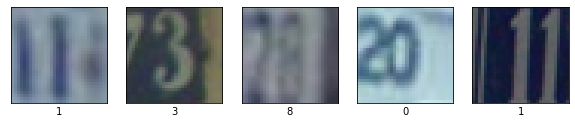

In [13]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n], cmap='gray')
        else:
            axes[n].imshow(X[n])
        axes[n].set_xlabel((np.argmax(y[n])+1)%10) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = [randint(0,len(X_train)) for i in range(5)]
X_random = [X_train[i] for i in images]
y_random = [y_train[i] for i in images]
plot_images(X_random, y_random)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [14]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow
from tensorflow.keras.models import model_from_json 

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

def load_model_from_file(base_dir, name, extension='.h5'):
  """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
  function following the Keras API. Don't change if you use TensorFlow. Otherwise,
  adapt as needed. 
  Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
  """
  try:
    # if a json description is available, load config and then weights
    if os.path.isfile(os.path.join(base_dir, name+'.json')):
      json_file = open(os.path.join(base_dir, name+'.json'), 'r')
      loaded_model_json = json_file.read()
      json_file.close()
      model = model_from_json(loaded_model_json)
      model.load_weights(os.path.join(base_dir, name+extension))
    # else just load the entire model from hdf5 file
    else:
      model = load_model(os.path.join(base_dir, name+extension))
  except OSError:
    shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
    return False
  return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
  """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
  adapt as needed. 
  Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
  """
  path = os.path.join(base_dir, name+extension)
  model.save(path)
  size = os.path.getsize(path)
  # If model > 100MB, store the weights and architecture only.
  if size > 100*1024*1024:
    print("Model larger than 100MB, storing weights only.")
    model.save_weights(path)
    model_json = model.to_json()
    with open(os.path.join(base_dir, name+".json"), "w") as json_file:
        json_file.write(model_json)

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# DO NOT EDIT
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        shout("Loading model from file", verbose)
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
        shout("Success!", verbose)
    # Report
    print(model.summary())
    lc = pd.DataFrame(learning_curves)
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    print(lc.apply(minMax))

## Part 1. Dense networks (10 points)

### Question 1.1: Baseline model (4 points)
- Build a dense network (with only dense layers) of at least 3 layers that is shaped like a pyramid: The first layer must have many nodes, and every subsequent layer must have increasingly fewer nodes, e.g. half as many. Implement a function 'build_model_1_1' that returns this model.
- You can explore different settings, but don't use any preprocessing or regularization yet. You should be able to achieve at least 70% accuracy, but more is of course better. Unless otherwise stated, you can use accuracy as the evaluation metric in all questions.
* Add a small description of your design choices (max. 500 characters) in 'answer_q_1_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- The name of the model should be 'model_1_1'. Evaluate it using the 'run_evaluation' function. For this question, you should not use more than 50 epochs.

Loading model from file
Success!
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               786688    
_________________________________________________________________
dense_21 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_23 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_24 (Dense)             (None, 10)                330       
Total params: 830,250
Trainable params: 830,250
Non-trainable params: 0
_______________

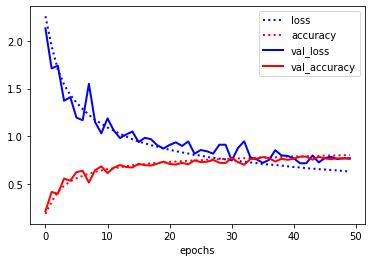

In [15]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

def build_model_1_1():
  model = models.Sequential()
  model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return model

run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir, 
               train=True, epochs=50, batch_size=200)
answer_q_1_1 = """
               layers: I tried six dense layers(first layer with 512 nodes), but the learning curve is a more erratic.
               optimizer='rmsprop': 'adagrad' makes learning curve more smooth but too slow, 'rmsprop' trains faster than 'adagrad'.
               batch_size=200: I experimented with different values and 200 has a better result.
               epochs=25 obtain maximum 75% accuracy, while 50 epochs improves max accuracy to over 78%.
               Althogh learning curve is not smooth, but it does not seem overfit too much.
               """
print("Answer is {} characters long".format(len(answer_q_1_1)))

### Question 1.2: Preprocessing (2 points)
Rerun the model, but now preprocess the data first by converting the images to 
greyscale. You can use the helper function below. If you want to do additional 
preprocessing, you can do that here, too.
* Store the preprocessed data as a tuple `preprocessed_split`
* Rerun and re-evaluate your model using the preprocessed data.
  * For the remainder of the assignment, always use the preprocessed data
* Explain what you did and interpret the results in 'answer_q_1_2'. Is the model
  better, if so, why?

In [16]:
# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

Loading model from file
Success!
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_24 (Reshape)         (None, 1024)              0         
_________________________________________________________________
dense_120 (Dense)            (None, 256)               262400    
_________________________________________________________________
dense_121 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_122 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_123 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_124 (Dense)            (None, 10)                330       
Total params: 305,962
Trainable params: 305,962
Non-trainable params: 0
______________

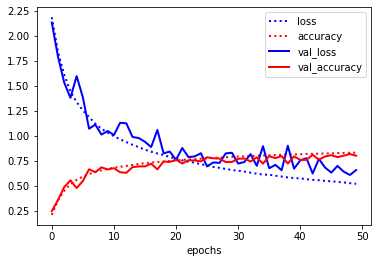

In [17]:
# Replace with the preprocessed data
# import cv2
# kernel = np.ones((5,5),np.float32)/25
# X_train_blur = []
# for i in range(len(X_train)):
#   # X_train_blur.append(cv2.filter2D(X_train[i],-1,kernel))
#   # X_train_blur.append(cv2.blur(X_train[i],(5,5)))
#   X_train_blur.append(cv2.GaussianBlur(X_train[i],(5,5),0))
# X_val_blur = []
# for i in range(len(X_val)):
#   # X_val_blur.append(cv2.filter2D(X_val[i],-1,kernel))
#   # X_val_blur.append(cv2.blur(X_val[i],(5,5)))
#   X_val_blur.append(cv2.GaussianBlur(X_val[i],(5,5),0))
# preprocessed_split = rgb2gray(np.array(X_train_blur)), rgb2gray(np.array(X_val_blur)), y_train, y_val

preprocessed_split = rgb2gray(X_train), rgb2gray(X_val), y_train, y_val

# Adjusted model
def build_model_1_2():
  model = models.Sequential()
  model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return model

# Evaluate. Use a new name 'model_1_2' to not overwrite the previous trained model
run_evaluation("model_1_2", build_model_1_2, preprocessed_split, base_dir, 
               train=True, epochs=50, batch_size=200)
answer_q_1_2 = """
               I experimented with different blur funtions to blur the images, but they do not increase the acuracy.
               The maximum arruracy increased to 82% by inputing grayscale images, which is slightly better than model_1_1(78%), 
               becasue color does not influence the shape recogenition but increase the complexity of images.
               there are also other ways to preprocess image data such as segmentation, but not helpful for our images.
               """
print("Answer is {} characters long".format(len(answer_q_1_2)))

### Question 1.3: Regularization and tuning (4 points)
* Regularize the model. You can explore (and combine) different techniques. What works best?
* Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
* Explain your findings and final design decisions. Retrain the model again on the preprocessed data and discuss the results.
* Return your model in function 'build_model_1_3' and write your answer in 'answer_q_1_3'

Using TensorFlow backend.


Loading model from file
Success!
Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_67 (Reshape)         (None, 1024)              0         
_________________________________________________________________
dense_335 (Dense)            (None, 256)               262400    
_________________________________________________________________
dense_336 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_337 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_338 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_339 (Dense)            (None, 10)                330       
Total params: 305,962
Trainable params: 305,962
Non-trainable params: 0
______________

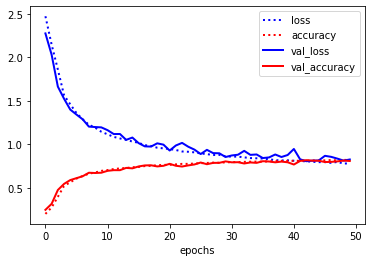

In [18]:
from tensorflow.keras import models
from tensorflow.keras import layers
from keras import regularizers
from tensorflow.keras import optimizers

def build_model_1_3():
  model = models.Sequential()
  model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
  model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
  model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
  model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
  model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizer=optimizers.Adamax(learning_rate=0.003),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return model

run_evaluation("model_1_3", build_model_1_3, preprocessed_split, base_dir, 
               train=True, epochs=50, batch_size=200)
answer_q_1_3 = """
              L2 regularization decay weights to make model overfitting slower. Adamax obtain a better accuracy 
              among Nadam, SGD, RMSprop and Adagrad.
              Although the maximum accuracy does not increase much than model_1_2, but the learning curve is more smooth.            
              BatchNormalization makes the learning curve very unstable and decreases the accuracy in this model.
              Dropout also does not help in this case although it is an effective and commonly used regularization techniques.
               """
print("Answer is {} characters long".format(len(answer_q_1_3)))

## Part 2. Convolutional neural networks (10 points)
### Question 2.1: Design a ConvNet (7 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 90% accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. 
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- You are allowed **800** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

Loading model from file
Success!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)      

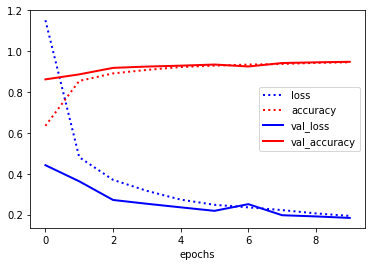

In [19]:
from tensorflow.keras import models
from tensorflow.keras import layers
from keras import regularizers
from tensorflow.keras import optimizers
preprocessed_split = rgb2gray(X_train), rgb2gray(X_val), y_train, y_val
def build_model_2_1():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='last_conv'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu' ))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(10, activation='softmax'))
  model.compile(loss='categorical_crossentropy',
              # optimizer=optimizers.RMSprop(lr=1e-3),
              optimizer=optimizers.Adamax(learning_rate=0.003),
              # optimizer=optimizers.SGD(learning_rate=0.01),
              metrics=['accuracy'])
  return model
run_evaluation("model_2_1", build_model_2_1, preprocessed_split, base_dir, 
               train=True, epochs=10, batch_size=64)
answer_q_2_1 = """
               six convolutional layers with increasing number of filters, add zero-padding to prevent losing information;
               add max-pooling layer to reduce the number of weigts(less overfitting), BatchNormalization and dropout to 
               speed up the training speed and reduce overfitting,
               but the same settings with L2 regularization in this model decreases the accuracy slightly;
               batch_size=32, 64 or 128 obtain almost equal accuracy, but size of 32 trains slower;
               optimizer=RMSprop(lr=1e-3) performs equally well with Adamax(learning_rate=0.003). 
               The model achieved maximum 95% accuracy, although the learning curve was a bit erratic at first 6 epochs, 
               it turns to be stable later and does not seem overfit with epochs=10, after 10 the model starts overfitting. 
               """
print("Answer is {} characters long".format(len(answer_q_2_1)))

### Question 2.2: Data Augmentation (3 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not?
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

Loading model from file
Success!
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)    

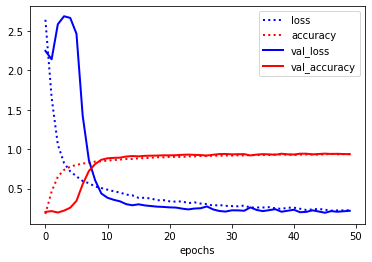

In [20]:
# Note that we build the same untrained model as in question 2.1 but store the 
# trained version as model_2_2. Change attributes as needed to run on augmented
# data
from tensorflow.keras import models
from tensorflow.keras import layers
from keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    # rescale=1./255,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    featurewise_center=True,
    featurewise_std_normalization=True,
    # samplewise_center=True,
    # samplewise_std_normalization=True,
#     zca_whitening=True,
    # horizontal_flip=True,
    # vertical_flip =True,
    # brightness_range=[0.2, 1.0],
    # zoom_range=[0.5,1.0],
    fill_mode='constant')
train_generator = train_datagen.flow(rgb2gray(X_train), y_train, batch_size=256)
augmented_split = train_generator, rgb2gray(X_val), y_val
run_evaluation("model_2_2", build_model_2_1, augmented_split, base_dir, 
               train=True, generator=True, epochs=50, batch_size=256)
answer_q_2_2 = """
               changing brightness(brightness_range), rescaling, rotation, shifting width and height result in 
               a very low accuracy, 
               flipping images randomly from horizontal or vertical decrease the accuracy,
               samplewise centerise and standard normalization reduce the accuracy,
               zoomming in 10% does not change performance obviously, but zoomming over 20% will reduce the accuracy,
               in conclusion, I could not find a good data genrator to improve the accuracy.
               """
print("Answer is {} characters long".format(len(answer_q_2_2)))

## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'.
* Summarize your findings in 'answer_q_3_1'

19858/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

test_accuracy_3_1:  0.9347


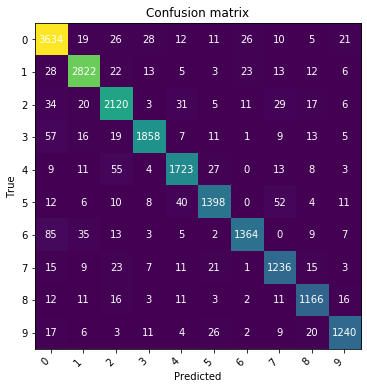

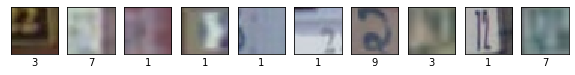

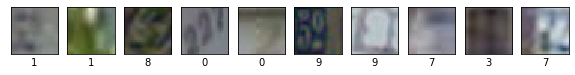

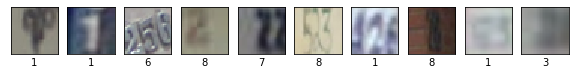

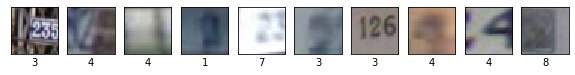

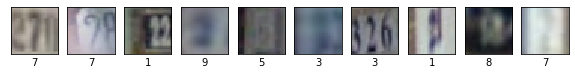

                                    50 misclassifications of number 2
Answer is 738 characters long


In [21]:
from sklearn.metrics import confusion_matrix
model_2_2 = load_model_from_file(base_dir, 'model_2_2')
test_loss, test_accuracy_3_1 = model_2_2.evaluate(rgb2gray(X_test), y_test)
print("test_accuracy_3_1:  {:.4f}".format(test_accuracy_3_1))
y_pred = model_2_2.predict(rgb2gray(X_test))

def plot_confusion_matrix():
  cm = confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))
  fig, ax = plt.subplots(figsize=(6,6))
  im = ax.imshow(cm)
  ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
  ax.set_xticklabels([0,1,2,3,4,5,6,7,8,9], rotation=45, ha="right")
  ax.set_yticklabels([0,1,2,3,4,5,6,7,8,9])
  ax.set_ylabel('True')
  ax.set_xlabel('Predicted')
  ax.set_title('Confusion matrix')
  for i in range(100):
    ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")

def my_plot_misclassifications(number):
  misclassified_samples = np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0]
  X_l = [X_test[i] for i in misclassified_samples if (np.argmax(y_test[i,:])+1 == number)]
  y_l = [y_pred[i] for i in misclassified_samples if (np.argmax(y_test[i,:])+1 == number)]
  if np.array(X_l).shape[0] > 60:
    plt_length = 60
  else:
    plt_length = np.array(X_l).shape[0]
  for i in range(0, plt_length-10, 10):
    plot_images(X_l[i:i+10], y_l[i:i+10])
  print("                                    50 misclassifications of number 2")

def plot_misclassifications():
  # args is the number you want to plot
  my_plot_misclassifications(2)

plot_confusion_matrix()
plot_misclassifications()

answer_q_3_1 = """
               test_accuracy_3_1 is 0.94;
               Often confused labels: 
                  0 is likely to be mislabeled to 6,3,2
                  6,3,2 are more likely to be mislabeled to 0, 
                  2 is also easily  to be mislabeled to 0 or 4, 
                  5 is more likely to be mislabeled to 4 and 7,
                  4 is likely to be mislabeled to 2;
              From the plot of 50 misclassifications of number 2, we see that over half percentage of errors is made 
              beacuse images are not clear,
              also some errors are made because the correct number is not in image center, 
              and some other errors related to interference by other numbers(noise).
               """
print("Answer is {} characters long".format(len(answer_q_3_1)))

### Question 3.2: Visualizing activations (4 points)
* Implement a function `plot_activations()` that returns the most interesting activations (feature maps). Select the first example from the test set. Retrieve and visualize the activations of model 2_2 for that example (make sure you load that model in the function), for every filter for different convolutional layers (at different depths in the network).
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

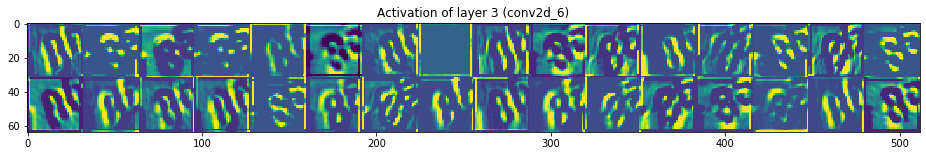

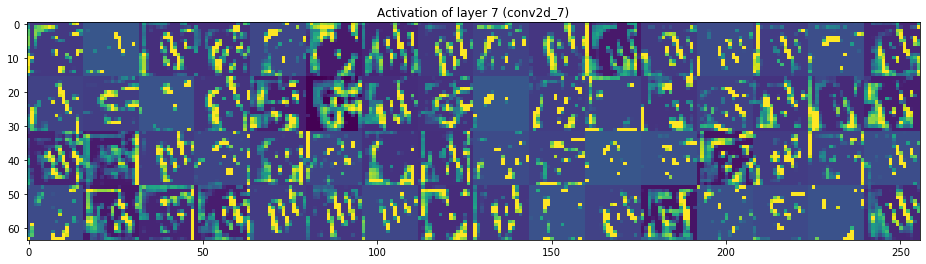

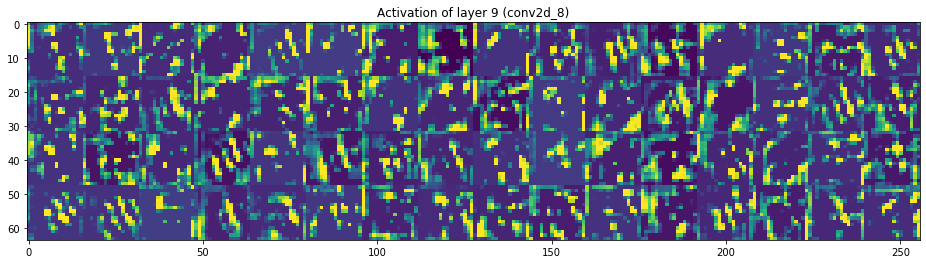

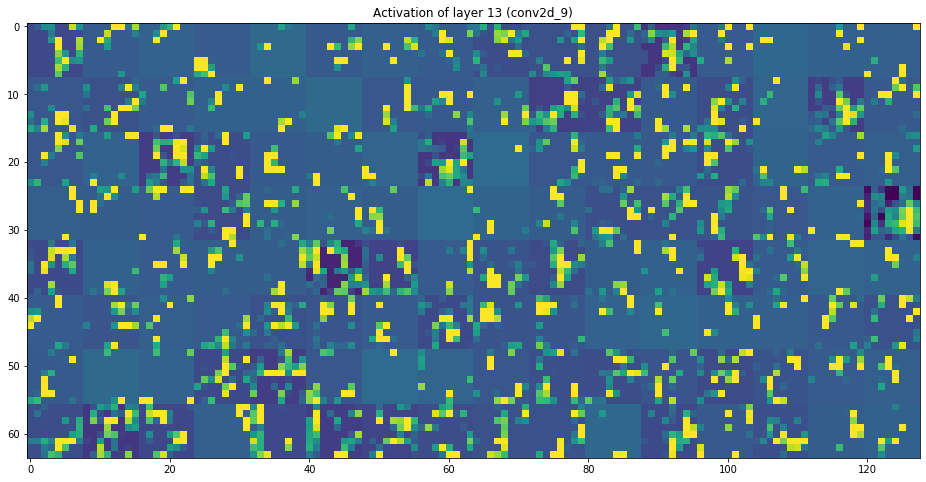

Answer is 507 characters long


In [22]:
def my_plot_activations(layer_index, activations, layer_names):
  images_per_row = 16
  start = layer_index
  end = layer_index+1
  for layer_name, layer_activation in zip(layer_names[start:end], activations[start:end]):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
      for row in range(images_per_row):
        channel_image = layer_activation[0,:, :, col * images_per_row + row]
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title("Activation of layer {} ({})".format(layer_index+1,layer_name))
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
  plt.show()

def plot_activations():
  model_3_2 = load_model_from_file(base_dir, 'model_2_2')
  layer_names = []
  for layer in model_3_2.layers[:len(model_3_2.layers)-6]:
    layer_names.append(layer.name)
  img_tensor = rgb2gray(X_test)[0]
  img_tensor = np.expand_dims(img_tensor, axis=0) 
  layer_outputs = [layer.output for layer in model_3_2.layers[:len(model_3_2.layers)-6]]
  activation_model = models.Model(inputs=model_3_2.input, outputs=layer_outputs)
  activations = activation_model.predict(img_tensor)

  # my_plot_activations(0, activations, layer_names) 
  my_plot_activations(2, activations, layer_names)
  my_plot_activations(6, activations, layer_names)
  my_plot_activations(8, activations, layer_names)
  my_plot_activations(12, activations, layer_names)
  # my_plot_activations(14, activations, layer_names)
  
plot_activations()

answer_q_3_2 = """
               The first convolutional layer detects different edges: some edges of 8, 6 can be seen, 
               and more edges can be seen in the second convolutional layer;
               The third convolutional layer detects some abstracts, outlines,
               The last three convolutional layers detect more abstract patterns, but less detail can be seen 
               because the model abstracts the features into general concepts that can be used to make a classification.
               """
print("Answer is {} characters long".format(len(answer_q_3_2)))

### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function `plot_activation_map()` that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, superimpossible the activation map over the image. If not, plot
them side by side. Implement a function 'plot_3_3' that returns the entire plot.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Predict Label: 8
True Label: 8


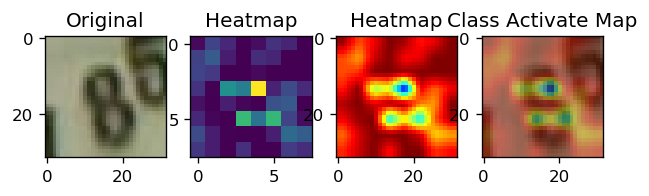

In [23]:
tf.compat.v1.disable_eager_execution()
from tensorflow.keras import backend as K
# from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import cv2

def my_plot_3_3(image_num):
  K.clear_session()
  model_3_3 = load_model_from_file(base_dir, 'model_2_2', extension='.h5')
  y_predict = model_3_3.predict(rgb2gray(X_test))
  print("Predict Label: " + str(np.argmax(y_predict[image_num],axis=-1)+1))
  print("True Label: " + str(np.argmax(y_test[image_num],axis=-1)+1))

  img = rgb2gray(X_test)[image_num]
  x = np.expand_dims(img, axis=0) 

  last_conv_layer = model_3_3.get_layer('last_conv')
  last_output = model_3_3.output[:,np.argmax(y_predict[image_num],axis=-1)]
  grads = K.gradients(last_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0,1,2))
  iterate = K.function([model_3_3.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(128):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap2 = np.uint8(255 * heatmap2)
  heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)
  img_original = np.uint8(255 * X_test[image_num])
  superimposed_img = cv2.addWeighted(img_original, 0.6, heatmap2, 0.4, 0)

  plt.rcParams['figure.dpi'] = 120
  plt.subplot(141)
  plt.title('Original')
  plt.imshow(X_test[image_num])
  plt.subplot(142)
  plt.title('Heatmap')
  plt.imshow(heatmap)
  plt.subplot(143)
  plt.title('Heatmap')
  plt.imshow(heatmap2)
  plt.subplot(144)
  plt.title('Class Activate Map')
  plt.imshow(superimposed_img)
  plt.show()

def plot_3_3():
  # args is the number you want to plot
  my_plot_3_3(0)

plot_3_3()


## Part 4. Transfer learning (10 points)
### Question 4.1 Fast feature extraction with VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds a dense layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers and evaluate whether that works better.
- Train the resulting model on the *original* (colored) training data
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

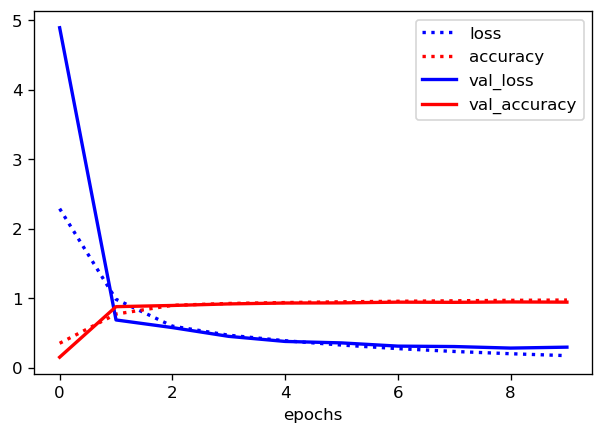

In [24]:
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras import models
from tensorflow.keras import layers
from keras import regularizers
from tensorflow.keras import optimizers
from keras.optimizers import SGD

preprocessed_split_4_1 = X_train, X_val, y_train, y_val

def build_model_4_1():
  conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(32, 32, 3))
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))
  conv_base.trainable = True
  set_trainable = False
  for layer in conv_base.layers:
      if layer.name == 'block5_conv1' or layer.name == 'block4_conv1' or layer.name == 'block3_conv1':
          set_trainable = True
      if set_trainable:
          layer.trainable = True
      else:
          layer.trainable = False
  model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adamax(learning_rate=0.001),
              # optimizer='rmsprop',
              metrics=['accuracy'])
  conv_base.summary()
  model.summary()
  return model

run_evaluation("model_4_1", build_model_4_1, preprocessed_split_4_1, base_dir, 
               train=True, epochs=10, batch_size=128)

answer_q_4_1 = """
              The accuracy increases from 0.56 to 0.82 by unfreezing the last convolutional block(block5_conv1-3) of vgg16, 
              and by unfreezing block4 and block3 the accuracy increased to 0.92 and 0.94 respectively, but it also increases 
              training time since there are more parameters to be trained.
              With two dense layers and no regularization, the learning curve is very erratic and overfitting easily. 
              Thus I add regularizations.
              The model starts to overfit a bit after 8 epochs.
               """
print("Answer is {} characters long".format(len(answer_q_4_1)))

### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layer) and returning the output. Embed the training and test data and store them to disk using the helper functions below. Implement a function `store_embeddings` that loads model_4_1 and stores all necessary embeddings to file. Make sure to run it once so that the embeddings are stored (and submitted).
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set. 
- Implement a function 'evaluate_pipeline' that evaluates a given pipeline on a given training and test set. 
- Implement a function 'evaluation_4_2' that evaluates your pipeline on the embedded training and test set (loaded from file) and returns the accuracy. 
- Describe what you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [25]:
# !pip install --quiet gama
import pickle
import gzip
from keras.models import Model
import skimage
from sklearn import pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

import logging
from gama import GamaClassifier, GamaRegressor
from gama.logging.GamaReport import GamaReport
from gama.postprocessing import EnsemblePostProcessing
from sklearn.metrics import log_loss

# np.warnings.filterwarnings('ignore')
tf.compat.v1.disable_eager_execution()

store_embeddings_flag = False

def store_embedding(X, name):  
  with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'wb') as file_pi:
    pickle.dump(X, file_pi)
def load_embedding(name):
  with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'rb') as file_pi:
    return pickle.load(file_pi)

def store_embeddings():
  """ Stores all necessary embeddings to file
  """
  model_4_2 = load_model_from_file(base_dir, 'model_4_1',extension='.h5')
  conv_base = model_4_2.get_layer('vgg16')
#   conv_base.summary()
  features_train=conv_base.predict(X_train)
  store_embedding(features_train, 'train')
  features_test=conv_base.predict(X_test)
  store_embedding(features_test, 'test')
  features_val=conv_base.predict(X_val)
  store_embedding(features_val, 'validation')

def my_reshape_data(X):
  n_samples = len(X)
  X_new = X.reshape((n_samples, -1))
  return X_new

def generate_pipeline():
  automl_with_ensemble = GamaClassifier(
      max_total_time=180,
      n_jobs=2,
#       verbosity=logging.INFO,
#       keep_analysis_log="covtype_ensemble.log",
      scoring='accuracy',
      post_processing_method=EnsemblePostProcessing(),
  )

  X_v = load_embedding('validation')
  if X_v is None:
    print('X_val embedding is null, store embeddings again')
    store_embeddings()
    X_v = load_embedding('validation')
  X_v = my_reshape_data(X_v)
  y_v = np.array([(np.argmax(y_val[i])+1)%10 for i in range(len(y_val))])
  grid_res = automl_with_ensemble.fit(X_v, y_v)
  best, = automl_with_ensemble._evaluation_library.n_best(1)
  best_pipeline = best.individual.pipeline
  # print(best_pipeline)
  return best_pipeline

def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
  """ Evaluates the given pipeline, trained on the given embedded training set and 
      evaluated on the supplied embedded test set. Returns the accuracy score.
  """
  X_tr = load_embedding('train')
  if X_tr is None:
    print('X_train embeddings is null, store embeddings again')
    store_embeddings()
    X_tr = load_embedding('train')
  X_te = load_embedding('test')
  if X_te is None:
    print('X_test embeddings is null, store embeddings again')
    store_embeddings()
    X_te = load_embedding('test')
  y_tr = np.array([(np.argmax(y_train[i])+1)%10 for i in range(len(y_train))])
  y_te = np.array([(np.argmax(y_test[i])+1)%10 for i in range(len(y_test))])
  test_score = pipeline.fit(my_reshape_data(X_tr), y_tr).score(my_reshape_data(X_te), y_te)
  return test_score

def evaluation_4_2(X_train, y_train, X_test, y_test):
  """ Runs 'evaluate_pipeline' with embedded versions of the input data 
  and returns the accuracy.
  """
  pipeline = generate_pipeline()
  if store_embeddings_flag == True:
      store_embeddings()
  test_score = evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test)
  print("test score: {:.3f}".format(test_score))

evaluation_4_2(X_train, y_train, X_test, y_test)

answer_q_4_2 = """
               I tried use grid search(my_gridSearch_classify and my_gridSearch_SVC_pipeline functions) to search a better 
               classifier and better parameter for pipeline, but it took too long time and SVC got a similar accuracy 
               with gama classifier.
               Finally, I chose gama classifier to search a best pipeline with validation embeddings, although in lab7 gama 
               classifier does not obtain a good performance on image datasets.
               The final test score is between 0.92 and 0.93 when unfreezing block4 and block 5 convolutional layers, 
               and it increaced up to 0.94 when unfreezing block3,4,5 convolutional layers.
               Although unfreezing block3,4,5 makes training very slow, it imporves the accuracy slightly, 
               I keep the final model like this.
               """
print("Answer is {} characters long".format(len(answer_q_4_2)))

#experiments
def my_gridSearch_classify():
  pipe =  Pipeline([
      ('scaler', StandardScaler()),
      ('classify', RandomForestClassifier())
  ])
  param_grid = [
      {'classify': [
          SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
          svm.SVC(kernel='linear'), RandomForestClassifier(), GradientBoostingClassifier()]}
  ]
  grid_search = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, scoring='accuracy', verbose=1, return_train_score=True)
  X_v = load_embedding('validation')
  if X_v is None:
    print('X_val embedding is null, store embeddings again')
    X_v = store_embeddings(X_val, 'validation')
  X_v = my_reshape_data(X_v)
  y_v = np.array([(np.argmax(y_val[i])+1)%10 for i in range(len(y_val))])
  grid_res = grid_search.fit(X_v, y_v)
  print(grid_res.best_params_)
  print(grid_res.best_score_)
  print(grid_res.best_estimator_)
  return grid_res

def my_gridSearch_SVC_pipeline():
  pipe =  Pipeline([
      ('scaler', StandardScaler()),
      ('classify', svm.SVC())
  ])
  param_grid = {'classify__C': np.logspace(-3, 3, num=4),
                'classify__gamma': np.logspace(-5, 1, num=4)}

  grid_search = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, scoring='accuracy', verbose=1, return_train_score=True)
  X_v = load_embedding('validation')
  if X_v is None:
    print('X_val embedding is null, store embeddings again')
    X_v = store_embeddings(X_val, 'validation')
  X_v = my_reshape_data(X_v)
  print(np.array(X_v).shape)
  y_v = np.array([(np.argmax(y_val[i])+1)%10 for i in range(len(y_val))])
  grid_res = grid_search.fit(X_v, y_v)
  print(grid_res.best_params_)
  print(grid_res.best_score_)
  print(grid_res.best_estimator_)
  return grid_res

test score: 0.938
Answer is 869 characters long
